## Continuation of Motivic salience work
cleaned up frp, MotivicSeperation_rough for refined evaluation

Following discussion with Julie, two suggested modifications for this evaluation:
- detect ternary time and mark it as distinct
- Count on the minime (or semi minimum) to handle ternary more consistently, instead of the semi breve (minim and semi breve time?)
- something else...

Also consider checking for longer motives, build the extension from 4 to 5 or 6 or 7

In [1]:
import music21 as m21
import copy
import operator
import json
import sys
import os
import time
from bisect import bisect_left, bisect_right
#import pygame

import math
import numpy as np 
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from collections import OrderedDict
from collections import deque
import pickle

import pingouin as pg

In [2]:
#os.chdir('/Users/finn/Documents/DDMAL/Scores/TestSet/Josquin_Song')
#os.chdir('/Users/finn/Documents/DDMAL/Scores/TestSet/Josquin_Missa_Lhomme_arme_sexti_toni')
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')

files = os.listdir()
files = sorted(files)
print(files)
f = files[2]
score = m21.converter.parse(f)

# score = m21.converter.parse('/Users/finn/Documents/DDMAL/Scores/TestSet/Josquin_Song/Jos2825-Mille_regretz.mid')
#score = m21.converter.parse('/Users/finn/Documents/DDMAL/Scores/TestSet/Josquin_Song/Jos2818-In_te_domine_speravi.mid')

In [3]:
f = files[37]
score = m21.converter.parse(f)
f

'Duf1002b-Missa_Ave_regina_celorum-Gloria.krn'

In [4]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/OckJos/Jos-master')
f='Jos0403c-Missa_Pange_lingua-Credo.krn'
score = m21.converter.parse(f)

In [5]:
score.show('midi')
#score.show()

## Definitions

In [7]:
# new definitinos for processing streams that deal better with triple meter issues

def Onset_List(m21stream):
    # this function returns the timepoints of note onsets (in score time, beats)
    # reduced to a list of unique timepoints
    allOns = []
    # first: is this a score?   
    if isinstance(m21stream,m21.stream.Score):  
        # retreive all note onsets from score
        for p in m21stream:
            if isinstance(p,m21.stream.Part):
                ons = Onset_List(p)
                allOns.extend(ons)
    if isinstance(m21stream,m21.stream.Part):
        flattenedp = m21stream.flat.notesAndRests
        rest_state = 0
        tie_state = 0
        for el in flattenedp:
            if isinstance(el,m21.note.Note):
                rest_state = 0
                if el.tie:
                    if el.tie.type == 'start':
                        allOns.append(float(el.offset))
                else:
                    allOns.append(float(el.offset))
            if isinstance(el,m21.note.Rest):
                if rest_state == 0:
                    allOns.append(float(el.offset))
                    rest_state = 1
        allOns.append(float(el.offset+el.quarterLength)) # end of last note or rest     
    # extract unique time values
    ons = np.unique(allOns)
    return ons

def Diatonic_Number(note):
    # translates a music21 note element to it's number in diatonic values, 
    # instead of chromatic like midi
    diatonic = {'C':0,'D':1,'E':2,'F':3,'G':4,'A':5,'B':6}
    dPitch = diatonic[note.name[0]] + 7 + note.octave*7
    return dPitch

def Onset_Pitch_List(m21part):
    # this function returns the timepoints and pitch of note onsets (in score time, beats) for parts
    # counts notes only as their diatonic numbers, not midi chromatic values
    # forcing el.offset and el.quarterlength to floats for indexing purposes
    ons = [[],[]]
    # input must be a part
    if isinstance(m21part,m21.stream.Part):    
        # retreive all note onsets from score
        flattenedp = m21part.flat.notesAndRests
        rest_state = 0
        for el in flattenedp:
            if isinstance(el,m21.note.Note):
                rest_state = 0
                if el.tie:
                        if el.tie.type == 'start':
                            ons[0].append(float(el.offset))
                            #ons[1].append(el.pitch.ps)
                            ons[1].append(Diatonic_Number(el))
                else:
                    ons[0].append(float(el.offset))
                    #ons[1].append(el.pitch.ps)
                    ons[1].append(Diatonic_Number(el))
            if isinstance(el,m21.note.Rest):
                 if rest_state == 0:
                    ons[0].append(float(el.offset)) 
                    ons[1].append(math.nan)
                    rest_state = 1
        ons[0].append(float(el.offset+el.quarterLength))
        ons[1].append(math.nan)
    return ons

def beat_Times(score):
    # generate complete beatTimes list for interpolated pitch sequences and melodies
    onsAll = Onset_List(score)
    step = np.min(np.diff(onsAll))
    if np.min(np.diff(onsAll))<1:
        step = np.min([np.min(np.diff(onsAll)),1-np.min(np.diff(onsAll))])
    rate_options = [8,6,4,3,2,1,0.5,0.25,0.125] # heavy handed fix of the rates to covenient beat values
    close_rate =np.argmin(abs(rate_options -(1/step)))
    new_step = 1/rate_options[close_rate]
    beatTime = np.arange(onsAll[0],onsAll[-1]+new_step,new_step)
    return beatTime    

def Pitch_Beat_Interpolate(onsets,pitchValues,beatTime):
    # function to produce pitch sequence at times beatTime from onset list with corresponding pitch values
    # apparently this kind of interpolation isn't an option in pandas?!
    # first align min values
    if onsets[0]>beatTime[0]:
        onsets = beatTime[0] + onsets
        pitchValues = math.nan + pitchValues
    beatTime_pitch = np.array(np.zeros_like(beatTime), dtype=np.float)
    onsets_h = np.array(onsets)
    for i_beats in range(len(beatTime)):
        r = np.max(np.where(onsets_h<=beatTime[i_beats]))
        beatTime_pitch[i_beats] = pitchValues[np.max(np.where(onsets_h<=beatTime[i_beats]))]
    return beatTime_pitch

def Score_Pitch_Steps(score):
    # from an m21 score, evaluate the pitch squence in each part and outputs
    # panda dataframe with colums of current pitch values for even sampling (on smallest subdivision)
    df_Score = pd.DataFrame()
    if isinstance(score,m21.stream.Score):  
        beatTime = beat_Times(score)
        df_Score = pd.DataFrame(index=beatTime)
        #df_Score['time'] = beatTime 
        #then run through all parts to first extract onsets and then build sequence
        k = 1
        for part in score:
            if isinstance(part,m21.stream.Part):
                if part.partName is None:
                    pn = 'Voice_' +str(k)
                    k+=1
                else:
                    pn = part.partName.strip('"')
                    if pn.startswith('Voice'):
                        pn = 'Voice_' +str(k)
                        k+=1
                onsets = Onset_Pitch_List(part)
                df_Score[pn] = Pitch_Beat_Interpolate(onsets[0],onsets[1],beatTime)
    return df_Score

def Voice_Seperation(score):
    # cues to blend: co entry (++), co-onsets, co-direction (comodulation)
    # count up from bass, who shares with them?
    df_pitchs = Score_Pitch_Steps(score)
    beatwise = df_pitchs
    beatwise = beatwise.fillna(-25) # CHEAT to catch entries, assuming here no voice leaps more than two octaves
    beatwise = beatwise.diff()
    beatwise = beatwise.mask(beatwise>25,math.nan) # Mark entries with nan(cheat)
    beatwise = beatwise.mask(beatwise<-25,0) # ignore ends of lines (cheat)
    beatwise = beatwise.mask(beatwise>0,1) # equate all increases
    beatwise = beatwise.mask(beatwise<0,-1) # equate all decreases
    beatwise = beatwise.fillna(2) # Distinguish entries by replacing nan with a higher values than changes in pitch
    beatwise = beatwise.mask(df_pitchs.isna(),math.nan) # reapply nan values where voices are quiet
    df_seperate = beatwise

    # for each voice, if voice seperation cues match those of a higher voice(s), make NA
    # or rather subtractive counting of independent streams, allowing for two or more voices per stream
    parts = df_seperate.columns
    for i in range(len(parts)-1):
        for j in range(i+1,len(parts)):
            df_seperate[parts[j]] = df_seperate[parts[j]].mask(df_seperate[parts[j]]==df_seperate[parts[i]],math.nan)
    df_seperate = 0.5*df_seperate.abs()
    
    #returned columns of voice seperationg actions, with coaction attributed to highest active voice. Entries 1, other actions contribute 0.5
    # note: onsets counted only if with melodic motion.
    return df_seperate

def Comp_Decay(series,beat_decay_slope):
    # Assume evenly sampled index of series
    A = series.fillna(0)
    B = series
    step = np.min(np.diff(series.index))
    # ar values
    ar = -(beat_decay_slope*step)*np.arange(0,1./beat_decay_slope,step)
    # smoothing without negatives
    for i in range(len(ar)):
        shifted = B.shift(periods=i+1,fill_value=0) + ar[i]
        shifted = shifted.mask(shifted<0,0)
        A += shifted.fillna(0)
        A = A.mask(A<0,0)
    return A

def Stream_Complexity_Smoothed(score):
    # smoothing voice seperation per line (highest) and calculating total
    #   With 8 beat linear decay extension of independence for entries
    #   And 4 beat linear decay extention of independence for distinct onset or direction of motion
    df_seperate = Voice_Seperation(score)
    A = Comp_Decay(df_seperate,0.2)
    
    # max and min the seperation intervals of each voice from the whole
    A = A.mask(A>1,1)
    A = A.mask(A==0,math.nan)
    # fill in the sustaining whole for the total
    B = A
    B = B.mask(df_seperate==0,1)
    A['Total'] = B.sum(1)
    return A

def Relative_Stream_Complexity(score):
    df_distinctions = Stream_Complexity_Smoothed(score)
    df_pitch = Score_Pitch_Steps(score)
    # get the number of voices active per moment 
    df_pitch = df_pitch.mask(df_pitch>1,1)
    df_pitch = Comp_Decay(df_pitch,0.2)
    df_pitch = df_pitch.mask(df_pitch>1,1)
    df_pitch = df_pitch.mask(df_pitch.isna(),0)
    df_active = df_pitch.sum(1)
    #df_active = df_active.mask(df_active<1,1)
    #df_active = df_active.pow(1./2)
    df_rel_complex = df_distinctions['Total']/df_active
    
    return df_rel_complex

# now for onset only measure of seperation
def Event_Beat_Interpolate(events,beatTime):
    # fit onset list into beatTime sequence
    beatTime_es = np.array(np.zeros_like(beatTime), dtype=np.float)
    beatTime_es.fill(np.nan)
    for es in events:
        i = np.max(np.where(beatTime<=es))
        beatTime_es[i] = 1
    return beatTime_es

def Score_Onset_Steps(score):
    beatTime = beat_Times(score)
    df_Score = pd.DataFrame(index=beatTime)
    k = 0
    for part in score:
        if isinstance(part,m21.stream.Part):
            pn = 'Voice_' + str(k)
            df_Score[pn] = Event_Beat_Interpolate(Onset_List(part),beatTime)
            k+=1
    return df_Score

def Onsets_Seperation(score):
    # count up from bass, who shares with them?
    df_seperate = Score_Onset_Steps(score)
    # for each voice, if voice seperation cues match those of a higher voice(s), make NA
    # or rather subtractive counting of independent streams, allowing for two or more voices per stream
    parts = df_seperate.columns
    for i in range(len(parts)-1):
        for j in range(i+1,len(parts)):
            df_seperate[parts[j]] = df_seperate[parts[j]].mask(df_seperate[parts[j]]==df_seperate[parts[i]],0)
    #returned columns of voice seperationg actions, with coaction attributed to highest active voice
    # counting only onsets, including repeated notes.
    return df_seperate

def Stream_Complexity_Onsets_Smoothed(score):
    # smoothing voice seperation per line (highest) and calculating total
    #   With 8 beat linear decay extension of independence for entries
    #   And 4 beat linear decay extention of independence for distinct onset or direction of motion
    df_seperate = Onsets_Seperation(score)
    A = Comp_Decay(df_seperate,0.2)
    # max and min the seperation intervals of each voice from the whole
    A = A.mask(A>1,1)
    A = A.mask(A==0,0)
    # fill in the sustaining whole for the total
    B = A
#     B = B.mask(df_seperate==0,1)
    A['Total'] = B.sum(1)
    return A

def Relative_Stream_Complexity_Onsets(score):
    df_distinctions = Stream_Complexity_Onsets_Smoothed(score)
    df_pitch = Score_Pitch_Steps(score)
    
    # get the number of voices active per moment 
    df_pitch = df_pitch.mask(df_pitch>1,1)
    #df_pitch = Comp_Decay(df_pitch,0.2)
    df_pitch = df_pitch.mask(df_pitch>1,1)
    df_pitch = df_pitch.mask(df_pitch.isna(),0)
    df_active = df_pitch.sum(1)
#     df_active = df_active.mask(df_active<1,1)
#     df_active = df_active.pow(1./2)
    df_rel_complex = df_distinctions['Total']/df_active
    df_rel_complex = df_rel_complex.mask(df_rel_complex>1,1)
    return df_rel_complex

In [250]:
def motive_heads(score):
    k=1
    all_heads = []
    max_dur_motive = 20 # "quarterlengths" apparently, minims
    for part in score:
        if isinstance(part,m21.stream.Part):
            if part.partName is None:
                pn = 'Voice_' +str(k)
                k+=1
            else:
                pn = part.partName.strip('"')
                if pn.startswith('Voice'):
                    pn = 'Voice_' +str(k)
                    k+=1
            
            L = Onset_Pitch_List(part)
            df_PartNotes = pd.DataFrame(index = L[0])
            df_PartNotes['Pitches'] = L[1]

            df_entries = df_PartNotes
            df_entries = df_entries.mask(df_entries.notna(),1)
            df_entries = df_entries.mask(df_entries.isna(),0)
            df_entries = df_entries.diff()
            df_entries = df_entries.mask(df_entries < 0,0)
            df_entries = df_entries.mask(df_entries.isna(),0)
            if pd.notna(L[1][0]):
                df_entries.Pitches.iloc[0] = 1.0
            A = df_entries[df_entries.Pitches == 1.0]
            Entrances = []
            for r in range(len(A)-1):
                ra = A.iloc[r].name
                rn = A.iloc[r+1].name-1
                seg = df_PartNotes.loc[(ra+0):min(ra+max_dur_motive,rn)] 
                if pd.isna(seg.Pitches.iloc[-1]): # remove final NaN of rest
                    seg = seg.iloc[:-1]
                Entrances.append(seg) # is this in minims? yes ish
            ra = A.iloc[len(A)-1].name
            seg = df_PartNotes.loc[(ra+0):(ra+max_dur_motive)] # cut sequences at rests
            if pd.isna(seg.Pitches.iloc[-1]): # remove final NaN of rest
                seg = seg.iloc[:-1]
            Entrances.append(seg) # is this in minims? yes ish
            for A in Entrances:
                if len(A)>2:
                    cols = {'Interval','Duration','Beat','Pitch','Time','Part'}
                    R = pd.DataFrame(index = list(np.arange(np.min([len(A),5]))),columns = cols)
                    R.loc[0,'Duration'] = A.iloc[1].name-A.iloc[0].name
                    R.loc[0,'Beat'] = np.mod(A.iloc[0].name,2) #  % 2 #.mod(2)
                    R.loc[0,'Pitch'] =  A.iloc[0].Pitches
                    R.loc[0,'Time'] = A.iloc[0].name
                    R.loc[0,'Part'] = pn
                    la = np.min([len(A),5])

                    for a in range(1,la):
                        R.loc[a,'Interval'] = A.iloc[a].Pitches-A.iloc[a-1].Pitches
                        if a<la-1:
                            R.loc[a,'Duration'] = A.iloc[a+1].name-A.iloc[a].name
                        R.loc[a,'Beat'] = np.mod(A.iloc[a].name,2)
                        R.loc[a,'Pitch'] =  A.iloc[a].Pitches
                        R.loc[a,'Time'] = A.iloc[a].name
                    if not pd.isna(sum(R.loc[1:,'Interval'])):
                        all_heads.append(R)
    heads = all_heads
    return heads 

def motive_shape(seg):
    la = len(seg)-1
    mhead = list(seg.Interval[1:la+1])
    mhead += list(seg.Duration[1:la])
    mhead += list(seg.Beat[1:la+1])
    meval = np.array(mhead)
    return meval

def min_heads(score): 
    K = motive_heads(score)
    K.sort(key=lambda x: x.Time.iloc[0])
    # sort heads by time before going through list. 
    heads = [K[0]]
    heads_vector = [motive_shape(K[0])]
    for h in K[1:]:
        ind = -1
        segEval = motive_shape(h)
        for i in range(len(heads_vector)):
            if np.array_equal(segEval, heads_vector[i]):
                ind = i
        if ind == -1:
            heads_vector.append(segEval)
            heads.append(h)  
    return heads

def Good_Match_Detection(score,motives):
# With a collection of motive heads, searchs full score to find segments with the same sequences of qualities.
    # prep score parts
    partStreams = []
    vn=1
    for part in score:
        if isinstance(part,m21.stream.Part):
            if part.partName is None:
                pn = 'Voice_' +str(vn)
                vn+=1
            else:
                pn = part.partName.strip('"')
                if pn.startswith('Voice'):
                    pn = 'Voice_' +str(vn)
                    vn+=1
            # gather part features
            S = Onset_Pitch_List(part)
            Seq = pd.DataFrame(data = {'Onsets':S[0],'Pitches':S[1]})
            R = pd.DataFrame()
            d = {'Interval':Seq['Pitches'].diff(),'Duration':pd.Series(S[0][1:])-pd.Series(S[0][:-1]),
                 'Beat':Seq.loc[1:,'Onsets'] % 2,'Pitch':Seq.loc[1:,'Pitches'],
                 'Time':Seq.loc[1:,'Onsets'],'Part':pn,'AltTime':0}
            R = pd.DataFrame(data = d)
            partStreams.append(R)

    # # search by head or motive
    good_matches = []
    for head in motives:
        h_matches = []
        motive = motive_shape(head)
        t = list(head.Time)
        la = len(head)-1
        for R in partStreams:
            # search part for potential matches
            for k in range(1,len(R)- la):
                # triage by onset beat of second note (could cute down times?)
                if R.loc[k,'Beat'] == head.loc[1,'Beat']:
                    sec = R.iloc[k-1:k+la]
                    seg = motive_shape(sec) #np.array(meval)
                    if sum(abs(motive - seg))==0:
                        sec.AltTime = t
                        h_matches.append(sec)
                    else: # loosen on the last note, given the longer time interval
                        if sum(abs(motive[:-3] - seg[:-3]))==0:
                            sec= R.iloc[k-1:k+la-1]
                            sec.AltTime = t[:-1]
                            h_matches.append(sec)
        if len(h_matches)>1:
            good_matches+=h_matches
    return good_matches

def get_closest_I(S, val):
    # from https://stackoverflow.com/a/55577604
    lower_idx = bisect_left(S, val)
    higher_idx = bisect_right(S, val)
    if higher_idx < len(S) and abs(S[higher_idx]-val)< abs(S[lower_idx]-val): #val is not in the list, chose closest
        return higher_idx
    else:                            #val is in the list
        return lower_idx

def seg_reconstruct_beats(seg,step):
    # to generate plotable segments of motives for visual interpretations
    seg = seg.reset_index()
    if seg.loc[0,'Interval']:
        seg.loc[0,'Time'] = seg.loc[1,'Time']-seg.loc[0,'Duration']
        seg.loc[0,'Pitch'] = seg.loc[1,'Pitch']-seg.loc[1,'Interval']
        
    if seg.iloc[-1, seg.columns.get_loc('Duration')]:
        seg.iloc[-1, seg.columns.get_loc('Duration')] = 1
        
    time_0 = seg.loc[1,'Time']-seg.loc[0,'Duration']
    time_end =seg.iloc[-1, seg.columns.get_loc('Time')]+seg.iloc[-1, seg.columns.get_loc('Duration')]
    motiveTime = np.arange(time_0,time_end+step,step)
    a = Pitch_Beat_Interpolate(list(seg.Time),list(seg.Pitch),motiveTime)
    df_PartNotes = pd.DataFrame(index = motiveTime,data = {'Pitch':a})
    return df_PartNotes

def Motivic_Alignments(score,good_matches): 
    
    df_motivic = Score_Pitch_Steps(score)
    step = np.min(np.diff(df_motivic.index))
    df_motivic = df_motivic.mask(df_motivic.notna(),0)

    for seg in good_matches:
        seg = seg.reset_index()
        seg.loc[1,'Time']
        seg_start = get_closest_I(df_motivic.index, seg.loc[1,'Time']-seg.loc[0,'Duration'])
        seg_time_end =seg.iloc[-1, seg.columns.get_loc('Time')]+seg.iloc[-1, seg.columns.get_loc('Duration')]
        seg_end = min(get_closest_I(df_motivic.index, seg_time_end),len(df_motivic)-1)

        m_start = get_closest_I(df_motivic.index, seg.loc[1,'AltTime']-seg.loc[0,'Duration'])
        # match to part and time points
    #         motiveTime = list(df_motivic.index[range(m_start,seg_end - seg_start + m_start)])
    #         df_motivic[seg.Part.iloc[0]].iloc[range(seg_start,seg_end)]=motiveTime
        m_end = min(seg_end - seg_start + m_start,len(df_motivic.index)-1)
        # match to part and time points
        motiveTime = list(df_motivic.index[range(m_start,m_end)])
        df_motivic.iloc[range(seg_start,seg_start + m_end - m_start),df_motivic.columns.get_loc(seg.loc[0,'Part'])]=motiveTime

    parts = df_motivic.columns
    df_seperate = df_motivic

    for i in range(len(parts)-1):
        for j in range(i+1,len(parts)):
            df_seperate[parts[j]] = df_seperate[parts[j]].mask(df_seperate[parts[j]]==df_seperate[parts[i]],math.nan)
    df_seperate = df_seperate.abs()
    # turn into zeros and ones
    A = df_seperate
    A = A.mask(A>0,1)
    A = A.mask(A.isna(),0)
    df_seperate = A

    return df_seperate
# def Motivic_Alignments(score,good_matches): 
#     df_motivic = Score_Pitch_Steps(score)
#     step = np.min(np.diff(df_motivic.index))
#     df_motivic = df_motivic.mask(df_motivic.notna(),0)
#     for seg in good_matches:
#         seg_start = get_closest_I(df_motivic.index, seg.Time.iloc[1]-seg.Duration.iloc[0])
#         seg_end = min(get_closest_I(df_motivic.index, seg.Time.iloc[-1]+seg.Duration.iloc[-1]),len(df_motivic)-1)
#         m_start = get_closest_I(df_motivic.index, seg.AltTime.iloc[1]-seg.Duration.iloc[0])
#         # match to part and time points
# #         motiveTime = list(df_motivic.index[range(m_start,seg_end - seg_start + m_start)])
# #         df_motivic[seg.Part.iloc[0]].iloc[range(seg_start,seg_end)]=motiveTime
#         m_end = min(seg_end - seg_start + m_start,len(df_motivic.index)-1)
#         # match to part and time points
#         motiveTime = list(df_motivic.index[range(m_start,m_end)])
#         df_motivic[seg.Part.iloc[0]].iloc[range(seg_start,seg_start + m_end - m_start)]=motiveTime
#         #df_motivic = df_motivic.mask(df_motivic.notna(),0) # WTF was this from from?
#     parts = df_motivic.columns
#     df_seperate = df_motivic
#     for i in range(len(parts)-1):
#         for j in range(i+1,len(parts)):
#             df_seperate[parts[j]] = df_seperate[parts[j]].mask(df_seperate[parts[j]]==df_seperate[parts[i]],math.nan)
#     df_seperate = df_seperate.abs()
#     # turn into zeros and ones
#     A = df_seperate
#     A = A.mask(A>0,1)
#     A = A.mask(A.isna(),0)
#     df_seperate = A
#     return df_seperate
    
def Motivic_Seperation(score): 
    K = min_heads(score)
    good_matches = Good_Match_Detection(score,K)    
    df_seperate = Motivic_Alignments(score,good_matches) 
    return df_seperate

def M_Stream_Complexity_Smoothed(score):
    # smoothing voice seperation per line (highest) and calculating total
    #   With 8 beat linear decay extension of independence for entries
    #   And 4 beat linear decay extention of independence for distinct onset or direction of motion
    
    df_seperate = Voice_Seperation(score)+Motivic_Seperation(score)
    df_seperate = df_seperate.mask(df_seperate>1,1)
    A = Comp_Decay(df_seperate,0.2)
    
    # max and min the seperation intervals of each voice from the whole
    A = A.mask(A>1,1)
    A = A.mask(A==0,math.nan)
    # fill in the sustaining whole for the total
    B = A
    B = B.mask(df_seperate==0,1)
    A['Total'] = B.sum(1)
    return A

In [18]:
# os.chdir('/Users/finn/Documents/DDMAL/Scores/OckJos/Jos-master')
# f='Jos0603e-Missa_Lhomme_arme_super_voces_musicales-Agnus.krn'
# score = m21.converter.parse(f)

## Sample Analysis

In [318]:
score = m21.converter.parse('/Users/finn/Documents/DDMAL/Scores/TestSet/Josquin_Song/Jos2818-In_te_domine_speravi.mid')
#score = m21.converter.parse('/Users/finn/Documents/DDMAL/Scores/TestSet/Josquin_Song/Jos2825-Mille_regretz.mid')
#score = m21.converter.parse(f)

# os.chdir('/Users/finn/Documents/DDMAL/Scores/OckJos/Jos-master')
# f='Jos0801e-Missa_Faisant_regretz-Agnus.krn'
# score = m21.converter.parse(f)

In [199]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
files = os.listdir()
files = sorted(files)

f=files[37]
print(f)
score = m21.converter.parse(f)

head = min_heads(score)
print(len(head))
tic = time.time()
# 3 is 4.382190942764282, 6 is 8.704284906387329, 7.822246074676514
ans = Good_Match_Detection(score,head)
toc = time.time()-tic
print(toc)

Duf1002b-Missa_Ave_regina_celorum-Gloria.krn
68
44.17116689682007


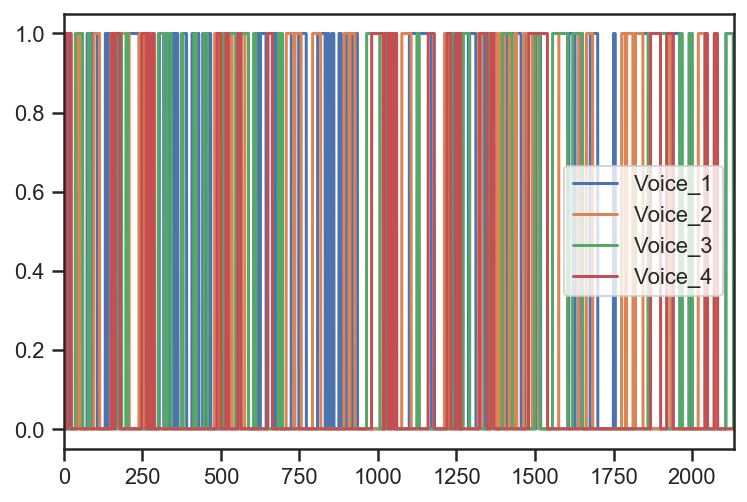

In [203]:
#a = Motivic_Alignments(score,ans)
df_seperate.plot()
plt.show()

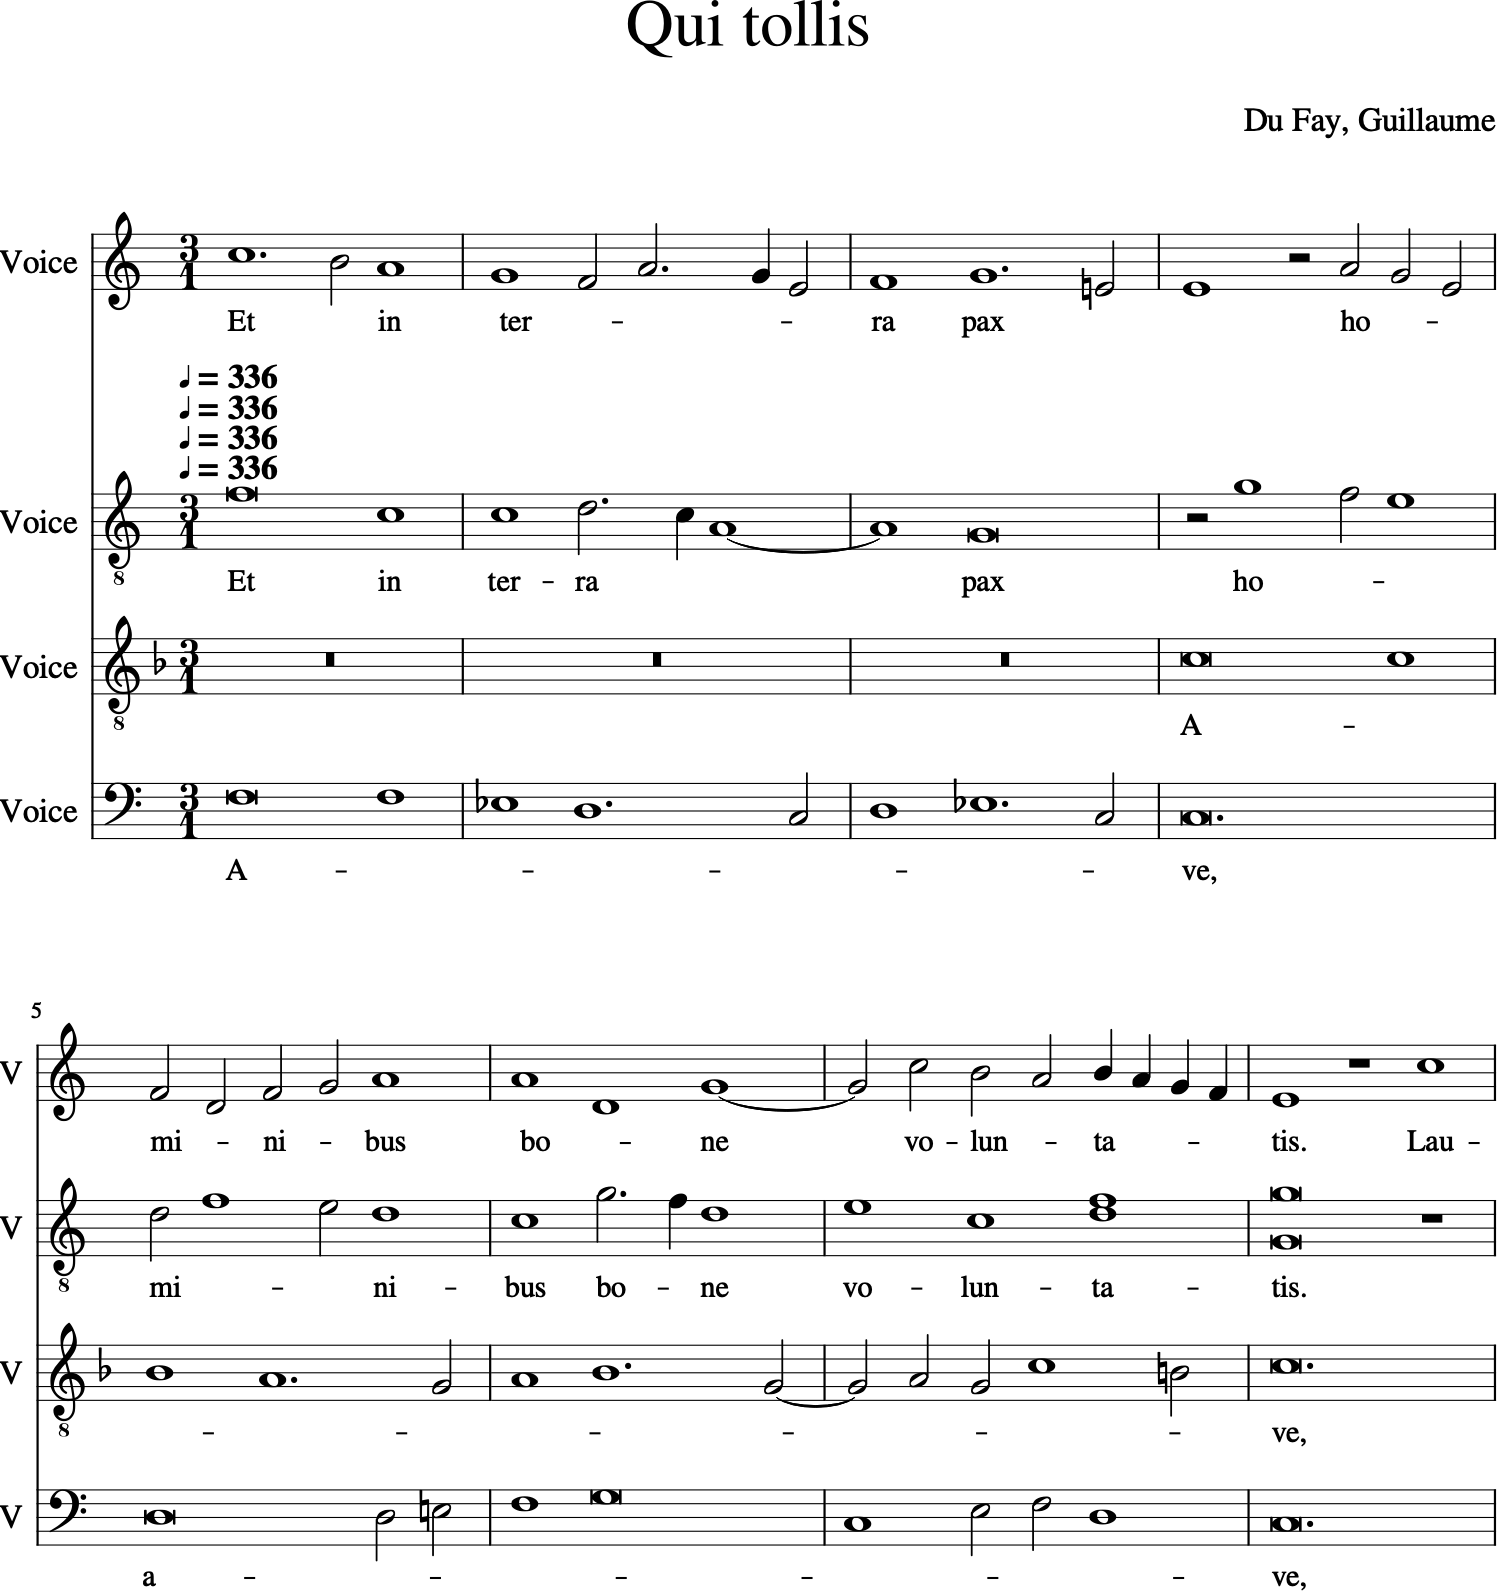

In [65]:
score.show()

In [ ]:
fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_seperate)

In [56]:
df_motivic.iloc[-10:]

,Voice_1,Voice_2,Voice_3,Voice_4
843.0,39.0,36.0,32.0,25.0
844.0,39.0,36.0,32.0,25.0
845.0,39.0,36.0,32.0,26.0
846.0,39.0,36.0,32.0,27.0
847.0,39.0,36.0,32.0,25.0
848.0,39.0,37.0,32.0,28.0
849.0,39.0,37.0,32.0,28.0
850.0,39.0,37.0,32.0,28.0
851.0,39.0,37.0,32.0,28.0
852.0,39.0,36.0,32.0,25.0


In [236]:
# from collections import Counter
# Counter(np.diff(onsAll))
f

'Duf1002b-Missa_Ave_regina_celorum-Gloria.krn'

0.4735288619995117
1.2930808067321777
47.641329765319824
48.95763087272644


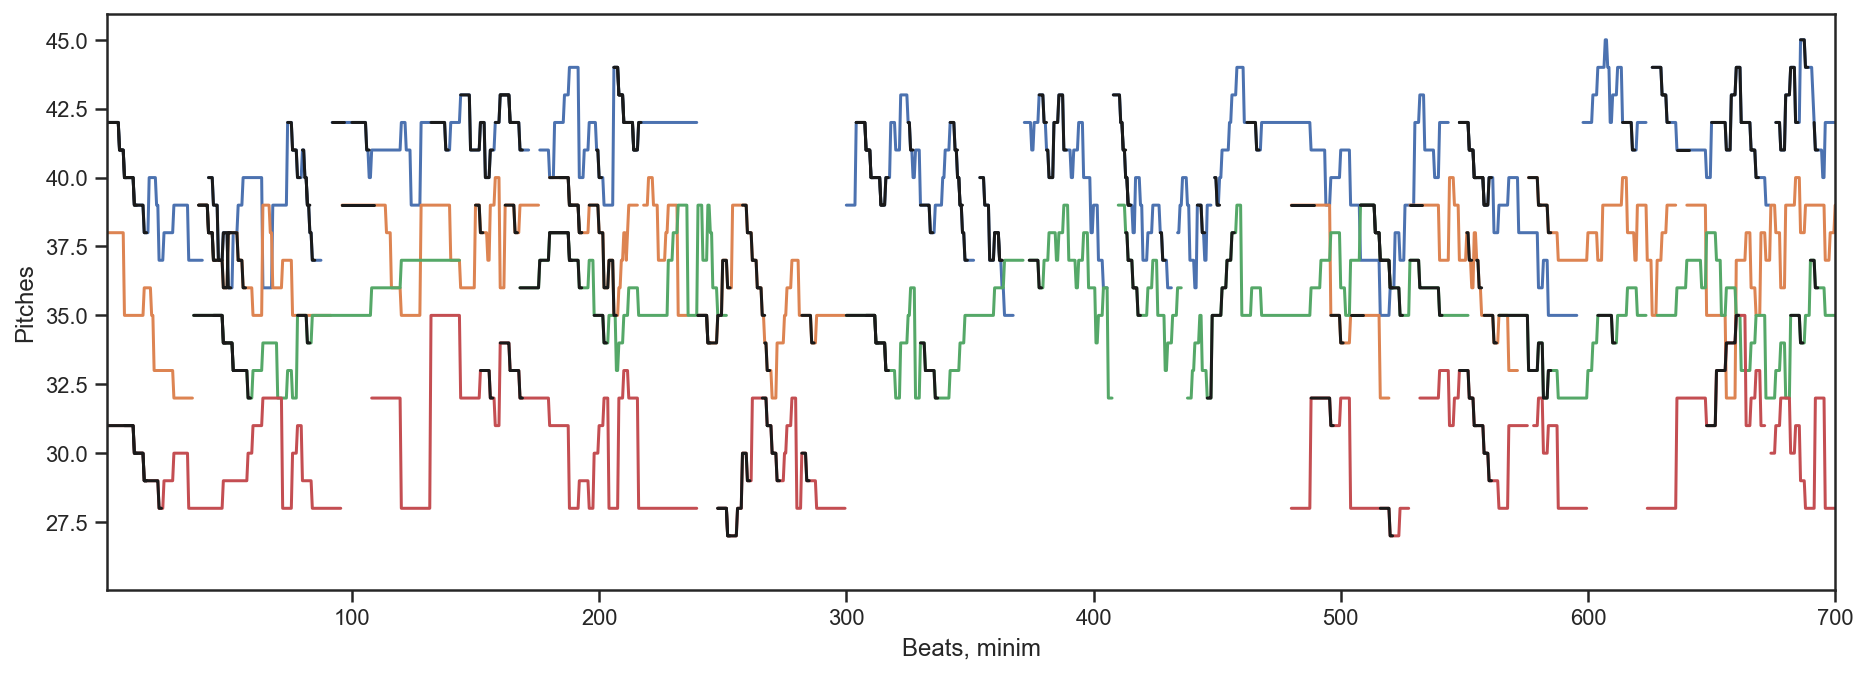

49.72946572303772
50.338501930236816
102.40809988975525


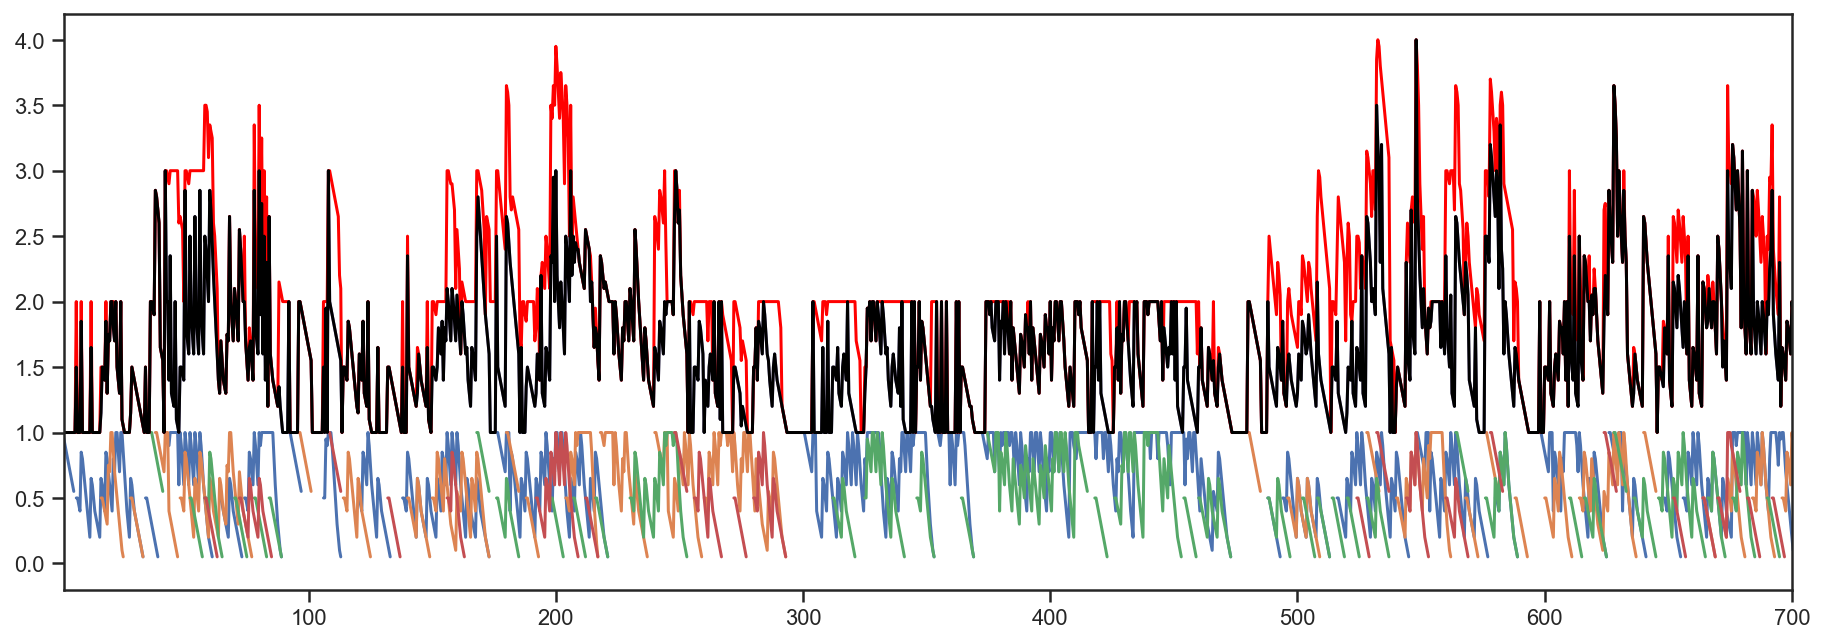

Voice_1    0.538172
Voice_2    0.484710
Voice_3    0.438996
Voice_4    0.412999
Total      1.396342
dtype: float64
Voice_1    0.831074
Voice_2    0.682281
Voice_3    0.704692
Voice_4    0.595043
Total      1.660352
dtype: float64
2132.0


In [254]:
tic = time.time()
x_r = np.array([1,700])
df_pitchs = Score_Pitch_Steps(score)

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_pitchs)
step = np.min(np.diff(df_pitchs.index))


toc = time.time() - tic
print(toc)

K = min_heads(score)
toc = time.time() - tic
print(toc)

good_matches = Good_Match_Detection(score,K)
toc = time.time() - tic
print(toc)

for seg in good_matches:
    df_pitchs = seg_reconstruct_beats(seg,step)
    axes.plot(df_pitchs,color='k')
# for seg in K:
#     df_pitchs = seg_reconstruct_beats(seg,step)
#     axes.plot(df_pitchs,color = 'magenta') 

toc = time.time() -tic
print(toc)   

plt.xlabel('Beats, minim')
plt.ylabel('Pitches')
axes.set_xbound(lower=x_r[0], upper=x_r[1])
locs, labels = plt.xticks()
#plt.savefig("plot1.png")
plt.show()

toc = time.time() -tic
print(toc)
df_seperated = Stream_Complexity_Smoothed(score)
toc = time.time() -tic
print(toc)

A = M_Stream_Complexity_Smoothed(score)
toc = time.time() -tic
print(toc)

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_seperated)
axes.plot(A['Total'],color="red")
axes.plot(df_seperated['Total'],color="black")
axes.set_xbound(lower=x_r[0], upper=x_r[1])
locs, labels = plt.xticks()
plt.show()

print(df_seperated.mean())
print(A.mean())
print(A.index[-1])


In [321]:
#os.chdir('/Users/finn/Documents/DDMAL/Scores/TestSet/Josquin_Song')
os.chdir('/Users/finn/Documents/DDMAL/Scores/TestSet/Josquin_Missa_Lhomme_arme_sexti_toni')

files = os.listdir()
files = sorted(files)
print(files[-10:])
f = files[-12]
print(f)
score = m21.converter.parse(f)

#score = m21.converter.parse('/Users/finn/Documents/DDMAL/Scores/TestSet/Josquin_Song/Jos2825-Mille_regretz.mid')
#score = m21.converter.parse('/Users/finn/Documents/DDMAL/Scores/TestSet/Josquin_Song/Jos2818-In_te_domine_speravi.mid')

['Jos0602d-Missa_Lhomme_arme_sexti_toni-Sanctus.txt', 'Jos0602d-Missa_Lhomme_arme_sexti_toni-Sanctus.xml', 'Jos0602e-Missa_Lhomme_arme_sexti_toni-Agnus-text (1).pdf', 'Jos0602e-Missa_Lhomme_arme_sexti_toni-Agnus-text.pdf', 'Jos0602e-Missa_Lhomme_arme_sexti_toni-Agnus.md2', 'Jos0602e-Missa_Lhomme_arme_sexti_toni-Agnus.mid', 'Jos0602e-Missa_Lhomme_arme_sexti_toni-Agnus.mp3', 'Jos0602e-Missa_Lhomme_arme_sexti_toni-Agnus.txt', 'Jos0602e-Missa_Lhomme_arme_sexti_toni-Agnus.xml', 'plot1.png']
Jos0602d-Missa_Lhomme_arme_sexti_toni-Sanctus.mid


Ad_coenam_Agni_Gloria_5.mid


/Users/finn/Library/Python/3.7/lib/python/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
/Users/finn/Library/Python/3.7/lib/python/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


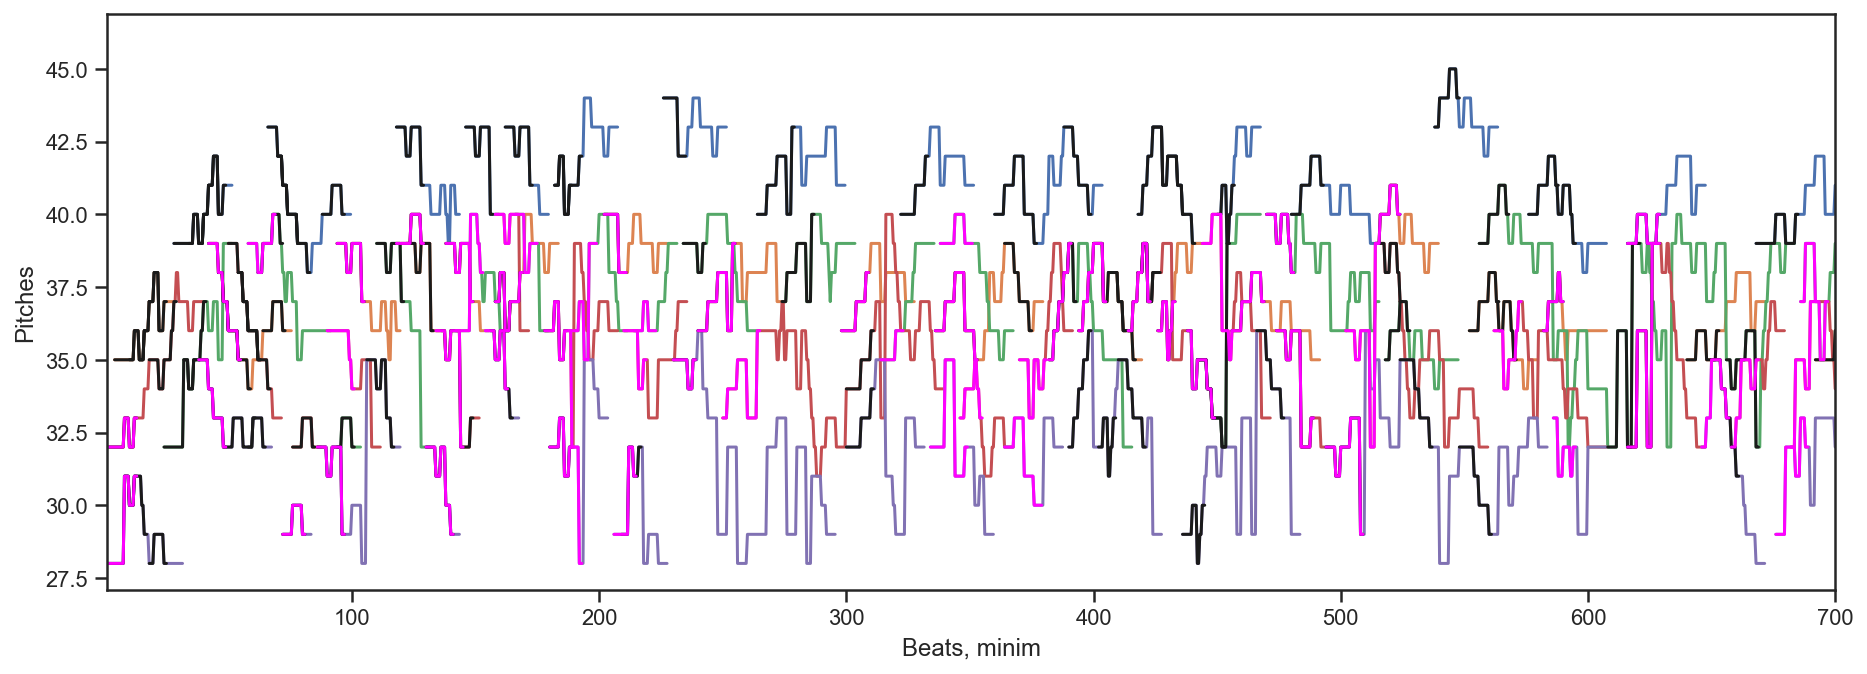

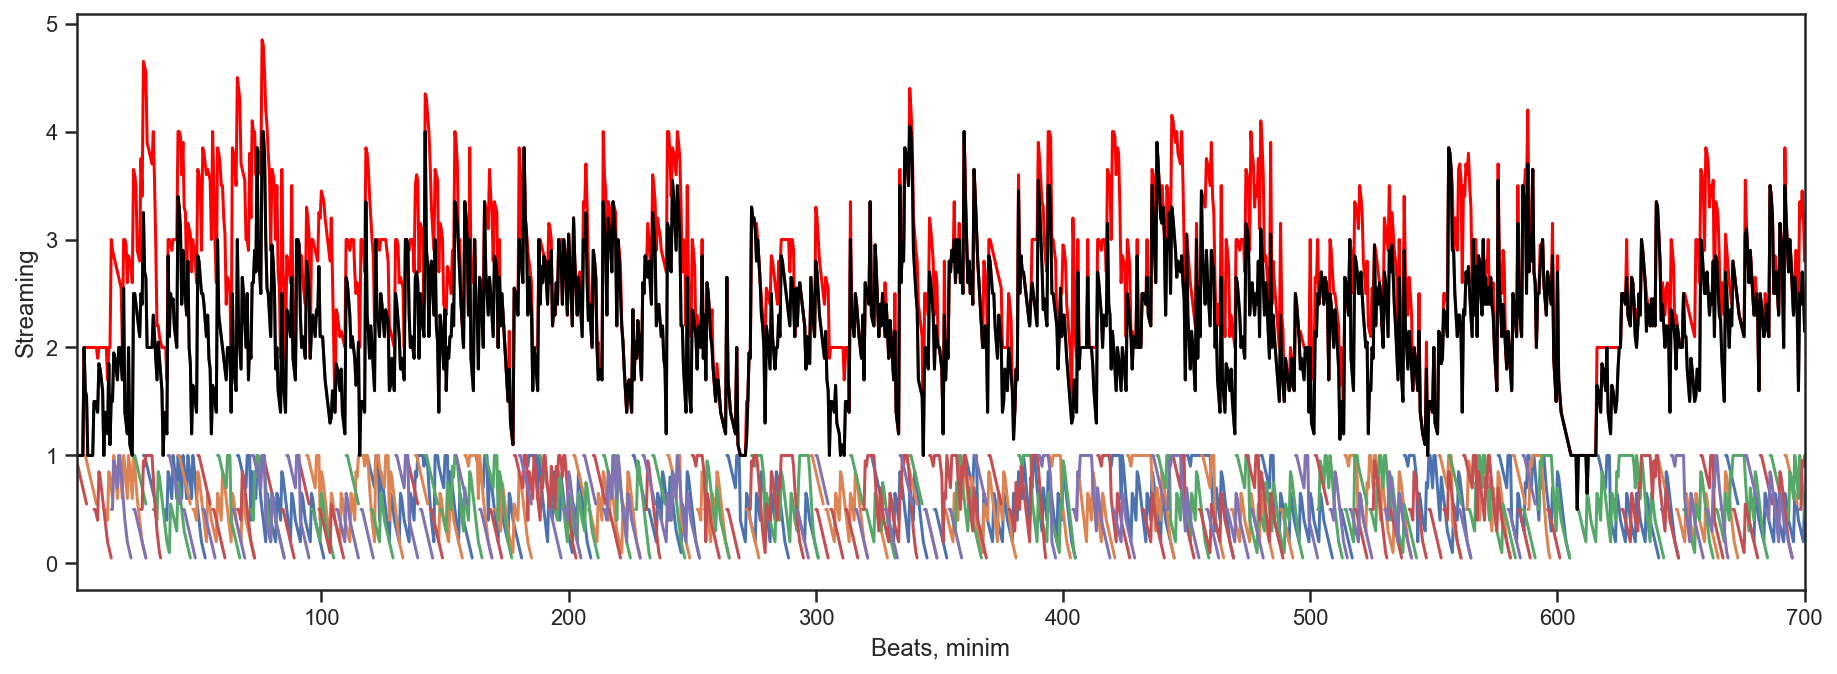

Voice_1    0.557959
Voice_2    0.547220
Voice_3    0.557819
Voice_4    0.527926
Voice_5    0.494653
Total      2.211981
dtype: float64
Voice_1    0.844388
Voice_2    0.819301
Voice_3    0.672286
Voice_4    0.654830
Voice_5    0.689679
Total      2.636704
dtype: float64
1216.0


In [73]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all/Palestrina/')
files = os.listdir()
files = sorted(files)
f = files[5]
print(f)
score = m21.converter.parse(files[5])
os.chdir('/Users/finn/Documents/DDMAL/dev/complexity/masses/')

x_r = np.array([1,700])
df_pitchs = Score_Pitch_Steps(score)

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_pitchs)
step = np.min(np.diff(df_pitchs.index))

K = min_heads(score)
good_matches = Good_Match_Detection(score,K)

for seg in good_matches:
    df_pitchs = seg_reconstruct_beats(seg,step)
    axes.plot(df_pitchs,color='k')
for seg in K:
    df_pitchs = seg_reconstruct_beats(seg,step)
    axes.plot(df_pitchs,color = 'magenta') 
    

plt.xlabel('Beats, minim')
plt.ylabel('Pitches')
axes.set_xbound(lower=x_r[0], upper=x_r[1])
# locs, labels = plt.xticks()
#plt.savefig("plot1.png")
plt.savefig("Example_Motivic_Selections.png",dpi = 200,bbox_inches = "tight")


plt.show()


df_seperated = Stream_Complexity_Smoothed(score)
A = M_Stream_Complexity_Smoothed(score)

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_seperated)
axes.plot(A['Total'],color="red")
axes.plot(df_seperated['Total'],color="black")
plt.xlabel('Beats, minim')
plt.ylabel('Streaming')
axes.set_xbound(lower=x_r[0], upper=x_r[1])
# locs, labels = plt.xticks()

plt.savefig("Example_MotivicAdditions.png",dpi = 200,bbox_inches = "tight")
plt.show()

print(df_seperated.mean())
print(A.mean())
print(A.index[-1])



Jos0301d-Missa_Ave_maris_stella-Sanctus.krn


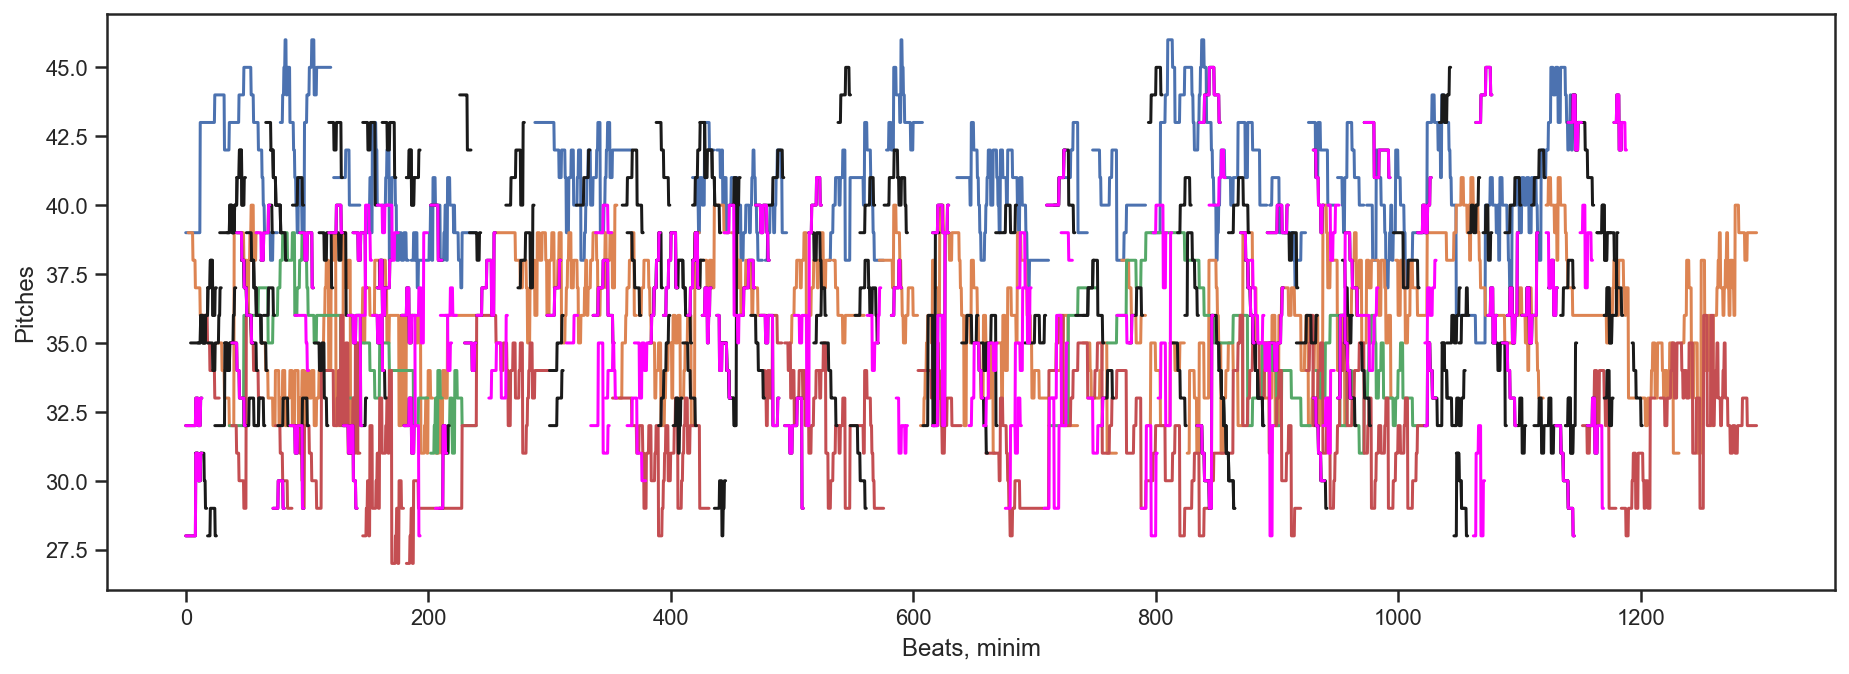

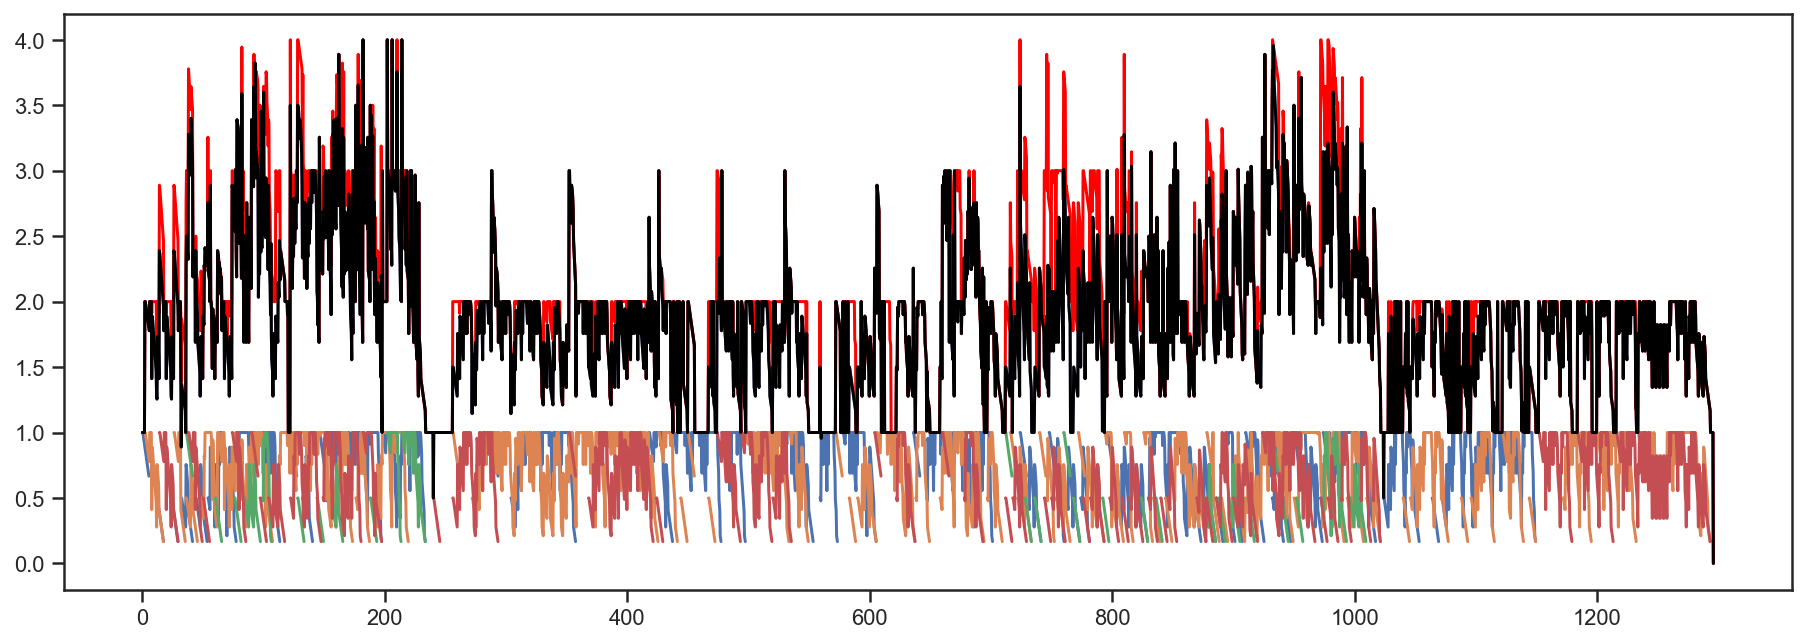

Voice_1    0.753930
Voice_2    0.711880
Voice_3    0.511276
Voice_4    0.649778
Total      1.860853
dtype: float64
Voice_1    0.861752
Voice_2    0.799715
Voice_3    0.611832
Voice_4    0.806208
Total      2.038673
dtype: float64
1296.0


In [43]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/OckJos/Jos-master')
files = os.listdir()
files = sorted(files)
f = files[5]# 5
# os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all')
# f = 'Bru1008b-Missa_Et_ecce_terre_motus-Gloria.krn'
print(f)
score = m21.converter.parse(f)

x_r = np.array([1,700])
df_pitchs = Score_Pitch_Steps(score)

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_pitchs)
step = np.min(np.diff(df_pitchs.index))

# K = min_heads(score)
# good_matches = Good_Match_Detection(score,K)

for seg in good_matches:
    df_pitchs = seg_reconstruct_beats(seg,step)
    axes.plot(df_pitchs,color='k')
for seg in K:
    df_pitchs = seg_reconstruct_beats(seg,step)
    axes.plot(df_pitchs,color = 'magenta') 
    

plt.xlabel('Beats, minim')
plt.ylabel('Pitches')
# axes.set_xbound(lower=x_r[0], upper=x_r[1])
# locs, labels = plt.xticks()
#plt.savefig("plot1.png")
plt.show()


df_seperated = Stream_Complexity_Smoothed(score)
A = M_Stream_Complexity_Smoothed(score)

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_seperated)
axes.plot(A['Total'],color="red")
axes.plot(df_seperated['Total'],color="black")
# axes.set_xbound(lower=x_r[0], upper=x_r[1])
# locs, labels = plt.xticks()
plt.show()

print(df_seperated.mean())
print(A.mean())
print(A.index[-1])

In [ ]:
tic = time.time()
#def Motivic_Alignments(score,good_matches): 
df_motivic = Score_Pitch_Steps(score)
step = np.min(np.diff(df_motivic.index))
df_motivic = df_motivic.mask(df_motivic.notna(),0)
m_time = df_motive.index

for seg in good_matches:
    seg_start = get_closest_I(df_motivic.index, seg.Time.iloc[1]-seg.Duration.iloc[0])
    seg_end = min(get_closest_I(df_motivic.index, seg.Time.iloc[-1]+seg.Duration.iloc[-1]),len(df_motivic)-1)
    m_start = get_closest_I(df_motivic.index, seg.AltTime.iloc[1]-seg.Duration.iloc[0])
    # match to part and time points
    motiveTime = list(df_motivic.index[range(m_start,seg_end - seg_start + m_start)])
    # df_motivic.iloc[range(seg_start,seg_end),(seg.Part.iloc[0])]=motiveTime
    df_motivic[seg.Part.iloc[0]].iloc[range(seg_start,seg_end)]=motiveTime
    #df_motivic = df_motivic.mask(df_motivic.notna(),0) # WTF was this from from?
parts = df_motivic.columns
df_seperate = df_motivic
for i in range(len(parts)-1):
    for j in range(i+1,len(parts)):
        df_seperate[parts[j]] = df_seperate[parts[j]].mask(df_seperate[parts[j]]==df_seperate[parts[i]],math.nan)
df_seperate = df_seperate.abs()
# turn into zeros and ones
A = df_seperate
A = A.mask(A>0,1)
A = A.mask(A.isna(),0)
df_seperate = A
#    return df_seperate
print(time.time()-tic)

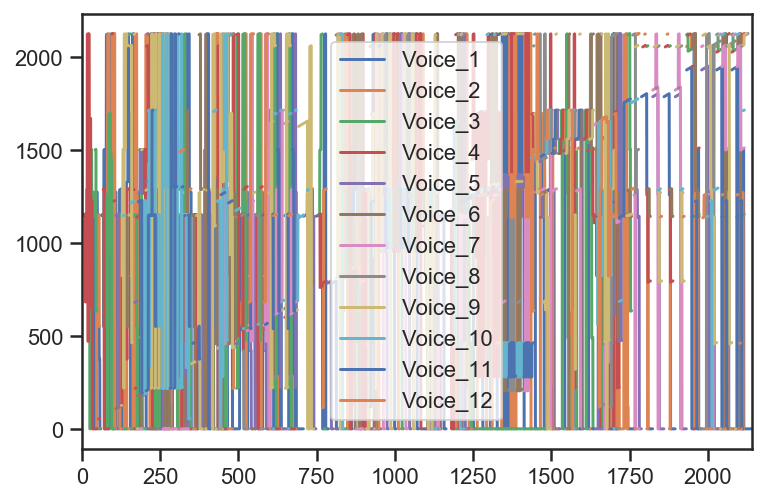

In [27]:
df_motivic.plot()

In [42]:
   # df_motivic.iloc[range(seg_start,seg_end),(seg.Part.iloc[0])]=motiveTime
df_motivic[seg.Part.iloc[0]].iloc[range(seg_start,seg_end)]=motiveTime
#df_motivic.loc[seg_start:seg_end,seg.Part.iloc[0]]
df_motivic[seg.Part.iloc[0]].iloc[range(seg_start,seg_end)]

28.0     0.0
28.5     0.5
29.0     1.0
29.5     1.5
30.0     2.0
30.5     2.5
31.0     3.0
31.5     3.5
32.0     4.0
32.5     4.5
33.0     5.0
33.5     5.5
34.0     6.0
34.5     6.5
35.0     7.0
35.5     7.5
36.0     8.0
36.5     8.5
37.0     9.0
37.5     9.5
38.0    10.0
38.5    10.5
39.0    11.0
39.5    11.5
40.0    12.0
40.5    12.5
41.0    13.0
41.5    13.5
Name: Voice_1, dtype: float64

In [29]:
seg_end

3562

Ad_coenam_Agni_Gloria_5.mid


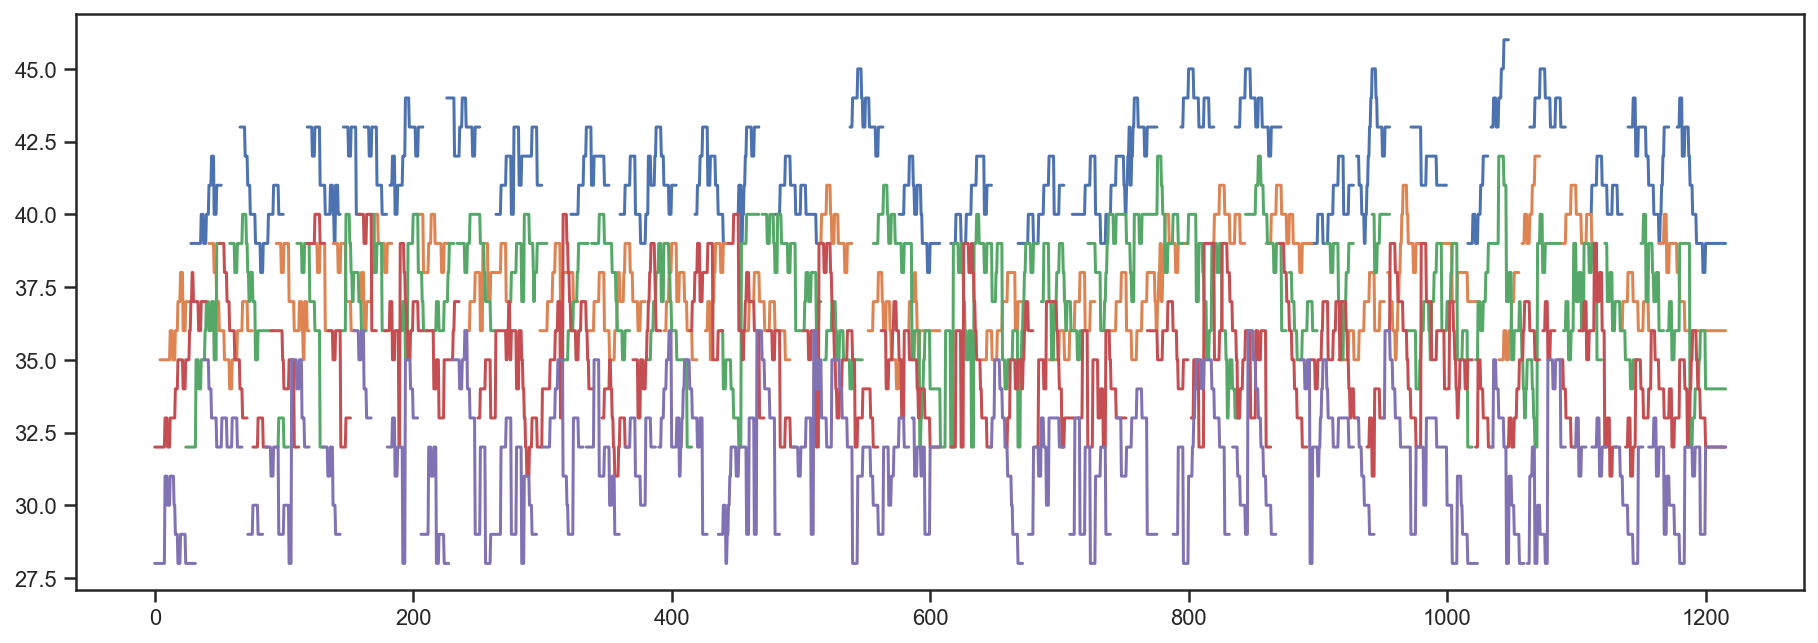

In [34]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all/Palestrina/')
files = os.listdir()
files = sorted(files)
f = files[5]
print(f)
score = m21.converter.parse(files[5])

x_r = np.array([1,700])
df_pitchs = Score_Pitch_Steps(score)

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_pitchs)
step = np.min(np.diff(df_pitchs.index))

K = min_heads(score)
good_matches = Good_Match_Detection(score,K)




Jos0301d-Missa_Ave_maris_stella-Sanctus.krn


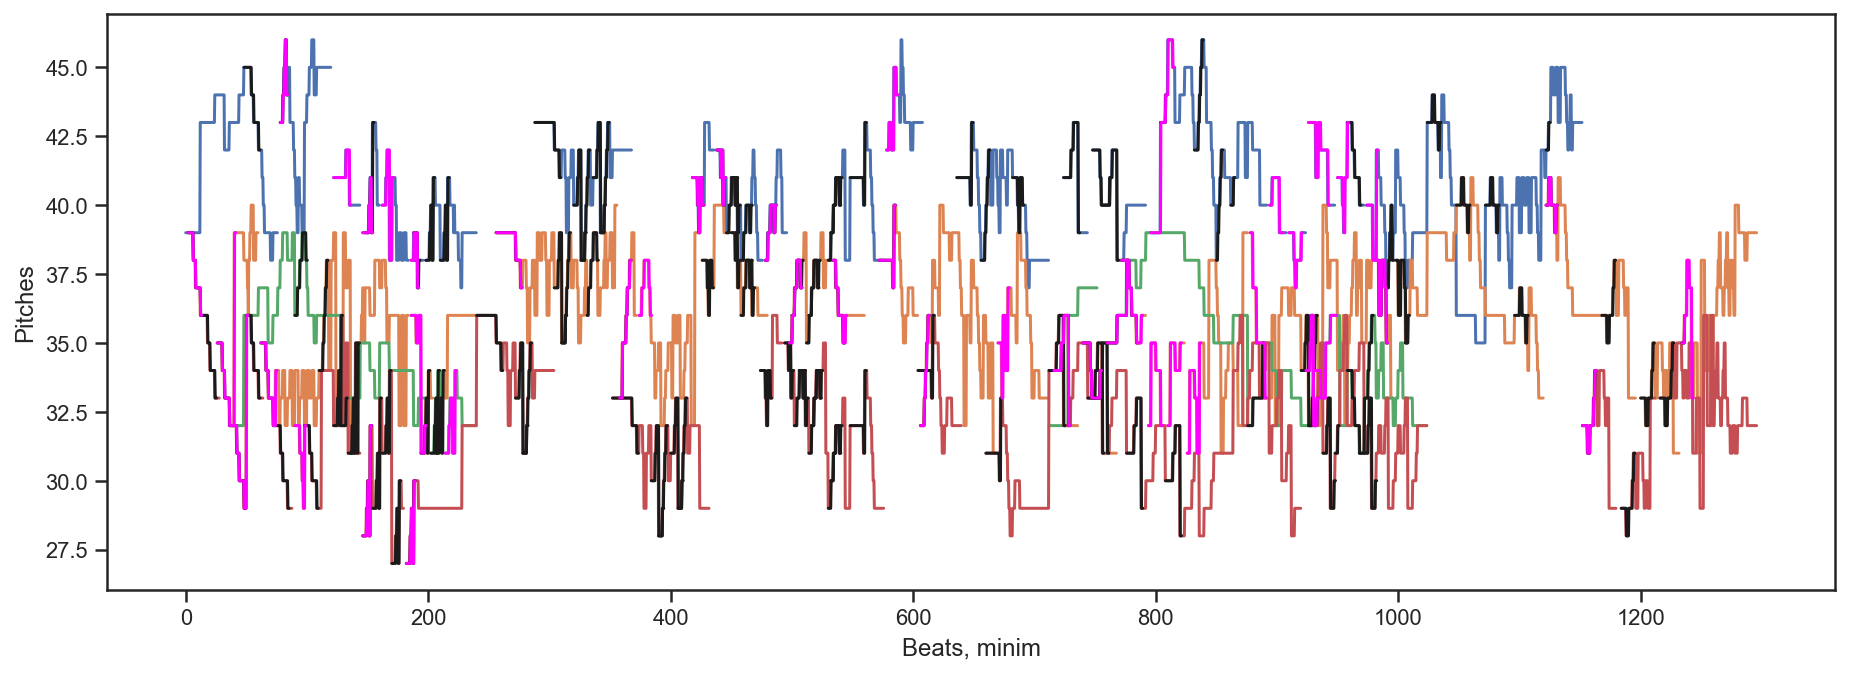

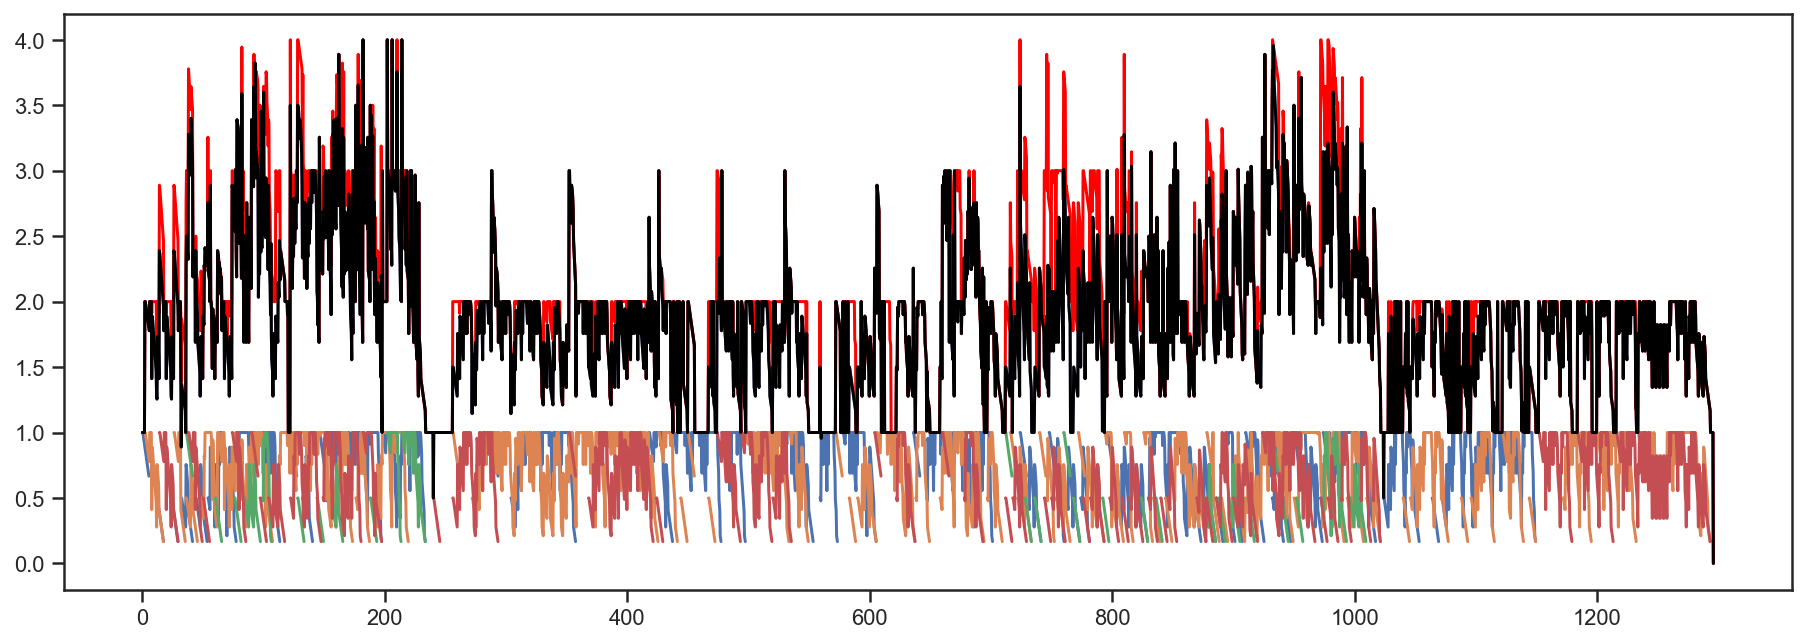

Voice_1    0.753930
Voice_2    0.711880
Voice_3    0.511276
Voice_4    0.649778
Total      1.860853
dtype: float64
Voice_1    0.861752
Voice_2    0.799715
Voice_3    0.611832
Voice_4    0.806208
Total      2.038673
dtype: float64
1296.0


In [457]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/OckJos/Jos-master')
files = os.listdir()
files = sorted(files)
f = files[5]# 5
print(f)
score = m21.converter.parse(f)

x_r = np.array([1,700])
df_pitchs = Score_Pitch_Steps(score)

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_pitchs)
step = np.min(np.diff(df_pitchs.index))

K = min_heads(score)
good_matches = Good_Match_Detection(score,K)

for seg in good_matches:
    df_pitchs = seg_reconstruct_beats(seg,step)
    axes.plot(df_pitchs,color='k')
for seg in K:
    df_pitchs = seg_reconstruct_beats(seg,step)
    axes.plot(df_pitchs,color = 'magenta') 
    

plt.xlabel('Beats, minim')
plt.ylabel('Pitches')
# axes.set_xbound(lower=x_r[0], upper=x_r[1])
# locs, labels = plt.xticks()
#plt.savefig("plot1.png")
plt.show()


df_seperated = Stream_Complexity_Smoothed(score)
A = M_Stream_Complexity_Smoothed(score)

fig= plt.figure(figsize=(15,5))
axes= fig.add_axes([0.1,0.1,0.8,0.8])
axes.plot(df_seperated)
axes.plot(A['Total'],color="red")
axes.plot(df_seperated['Total'],color="black")
# axes.set_xbound(lower=x_r[0], upper=x_r[1])
# locs, labels = plt.xticks()
plt.show()

print(df_seperated.mean())
print(A.mean())
print(A.index[-1])

In [40]:
#def Motivic_Seperation(score): 
K = min_heads(score)
good_matches = Good_Match_Detection(score,K)

df_motivic = Score_Pitch_Steps(score)
step = np.min(np.diff(df_motivic.index))

df_motivic = df_motivic.mask(df_motivic.notna(),0)


    
#    return df_seperate

In [41]:
for seg in good_matches:
    seg_beats = seg_reconstruct_beats(seg,step)
    
    # match to part and time points
    motiveTime = list(seg_beats.index - seg.Time.iloc[1] + seg.AltTime.iloc[1])
    if step<0.5:
        motiveTime=np.round(motiveTime/step)*step
    # index hack for 0 starting series, to compensation for uncertaintine
    df_motivic[seg.Part.iloc[0]][seg_beats.index[0]-0.05:seg_beats.index[-1]+0.05]=motiveTime

# parts = df_motivic.columns
# df_seperate = df_motivic
# for i in range(len(parts)-1):
#     for j in range(i+1,len(parts)):
#         df_seperate[parts[j]] = df_seperate[parts[j]].mask(df_seperate[parts[j]]==df_seperate[parts[i]],math.nan)
# df_seperate = df_seperate.abs()
# # turn into zeros and ones
# A = df_seperate
# A = A.mask(A>0,1)
# A = A.mask(A.isna(),0)
# df_seperate = A

In [458]:
seg

,Interval,Duration,Beat,Pitch,Time,Part
0,NaN,2,0,35,1234,Voice_2
1,1,2,0,36,1236,NaN
2,2,2,0,38,1238,NaN
3,-1,2,0,37,1240,NaN
4,-4,1,0,33,1242,NaN


In [216]:
len(seg_beats.index)

16

In [215]:
seg_beats.index[0]

78.0

In [217]:
len(motiveTime)

16

In [43]:
df_motivic[seg.Part.iloc[0]][seg_beats.index[0]-0.05:seg_beats.index[-1]+0.05]

1216.000000    1152.000000
1216.333333    1152.333333
1216.666667    1152.666667
1217.000000    1153.000000
1217.333333    1153.333333
1217.666667    1153.666667
1218.000000    1154.000000
1218.333333    1154.333333
1218.666667    1154.666667
1219.000000    1155.000000
1219.333333    1155.333333
1219.666667    1155.666667
1220.000000    1156.000000
1220.333333    1156.333333
1220.666667    1156.666667
1221.000000    1157.000000
1221.333333    1157.333333
1221.666667    1157.666667
1222.000000    1158.000000
1222.333333    1158.333333
1222.666667    1158.666667
1223.000000    1159.000000
1223.333333    1159.333333
1223.666667    1159.666667
1224.000000    1160.000000
1224.333333    1160.333333
1224.666667    1160.666667
1225.000000    1161.000000
1225.333333    1161.333333
1225.666667    1161.666667
1226.000000    1162.000000
1226.333333    1162.333333
Name: Voice_4, dtype: float64

In [44]:
seg_beats.index

Float64Index([            1216.0, 1216.3333333333333, 1216.6666666666665,
              1216.9999999999998,  1217.333333333333, 1217.6666666666663,
              1217.9999999999995, 1218.3333333333328,  1218.666666666666,
              1218.9999999999993, 1219.3333333333326, 1219.6666666666658,
               1219.999999999999, 1220.3333333333323, 1220.6666666666656,
              1220.9999999999989, 1221.3333333333321, 1221.6666666666654,
              1221.9999999999986,  1222.333333333332, 1222.6666666666652,
              1222.9999999999984, 1223.3333333333317,  1223.666666666665,
              1223.9999999999982, 1224.3333333333314, 1224.6666666666647,
               1224.999999999998, 1225.3333333333312, 1225.6666666666645,
              1225.9999999999977,  1226.333333333331],
             dtype='float64')

In [45]:
motiveTime

array([1152.        , 1152.33333333, 1152.66666667, 1153.        ,
       1153.33333333, 1153.66666667, 1154.        , 1154.33333333,
       1154.66666667, 1155.        , 1155.33333333, 1155.66666667,
       1156.        , 1156.33333333, 1156.66666667, 1157.        ,
       1157.33333333, 1157.66666667, 1158.        , 1158.33333333,
       1158.66666667, 1159.        , 1159.33333333, 1159.66666667,
       1160.        , 1160.33333333, 1160.66666667, 1161.        ,
       1161.33333333, 1161.66666667, 1162.        , 1162.33333333])

In [255]:
1482/5

296.4

In [256]:
5*100/60

8.333333333333334

In [270]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all/Victoria/')
files = os.listdir()
files = sorted(files)
f = files[9]
print(f)
score = m21.converter.parse(f)

f = files[10]
print(f)
score2 = m21.converter.parse(f)




Ascendens_Christus_In_Altum-4-Sanctus.mid
Ascendens_Christus_In_Altum-5-Benedictus.mid


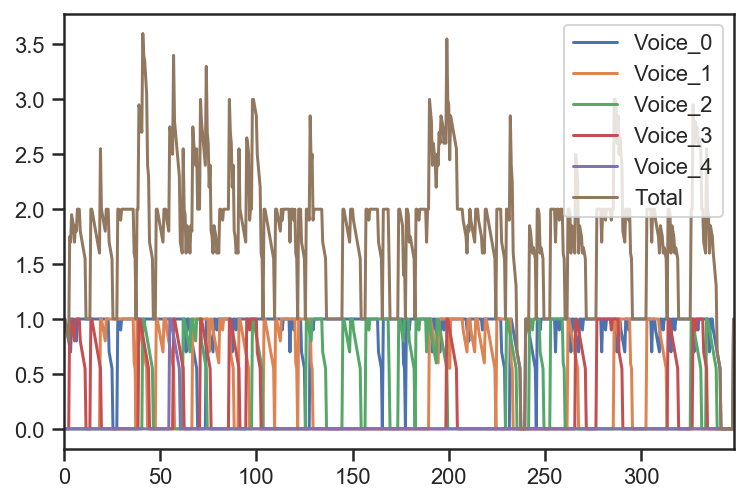

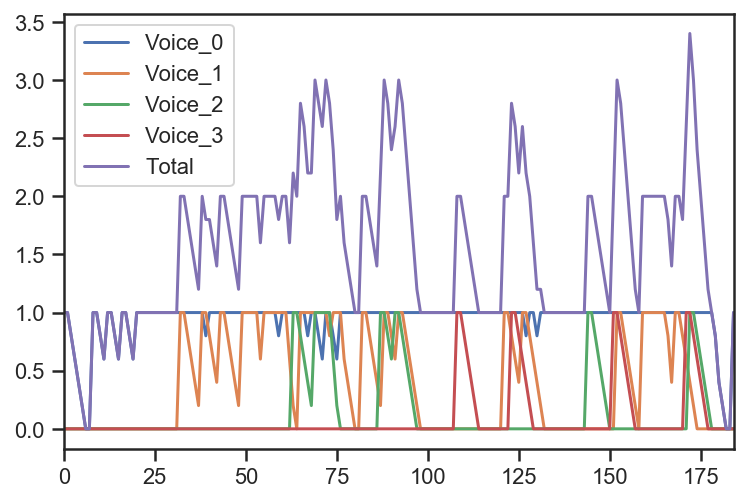

697
882


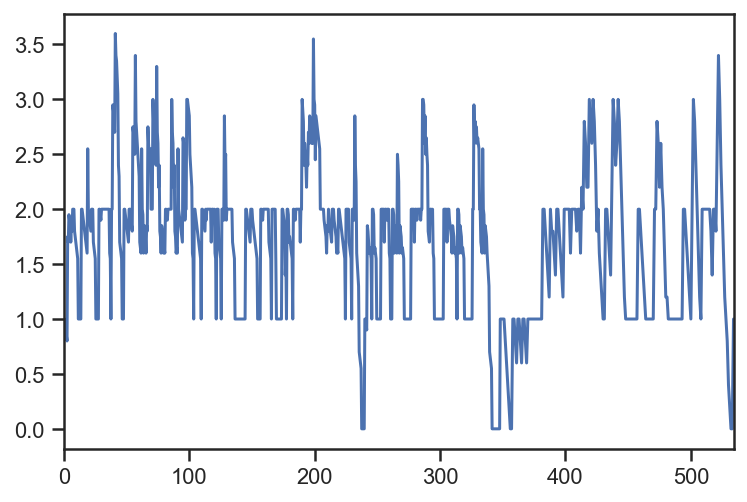

In [284]:
Onsets_seperated = []
df_seperated = Stream_Complexity_Onsets_Smoothed(score)
Onsets_seperated.append(df_seperated['Total'])

df_seperated.plot()
plt.show()

df_seperated = Stream_Complexity_Onsets_Smoothed(score2)

df_seperated.plot()
plt.show()


print(len(Onsets_seperated[-1]))
df_seperated['Total'].index = df_seperated['Total'].index + max(Onsets_seperated[-1].index) + 2
Onsets_seperated[-1] = Onsets_seperated[-1].append(df_seperated['Total'])
print(len(Onsets_seperated[-1]))


Onsets_seperated[-1].plot()
plt.show()




In [282]:
df_seperated['Total'].index = df_seperated['Total'].index + max(Onsets_seperated[-1].index) + 1
df_seperated['Total']

349.0    1.0
350.0    1.0
351.0    0.8
352.0    0.6
353.0    0.4
        ... 
529.0    0.4
530.0    0.2
531.0    0.0
532.0    0.0
533.0    1.0
Name: Total, Length: 185, dtype: float64

In [292]:

os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all/Victoria/')
files = os.listdir()
files = sorted(files)

mvmt = ['Kyrie','Gloria','Credo','Sanctus','Benedictus','Agnus']
composer = 'Tomás Luis de Victoria'
c_id = 'Vic'
tic = time.time()

for i in []:#range(5,len(files)):
    f = files[i]
    if f.endswith('mid'): 
        a = f.split('-')
        # ignore the number of voices listed in the title?
        movement_No = 1
        endbit = a[-1].split('.')
        a[-1] = endbit[0]
        movement = a[-1]
        m_id = c_id + str(1000 + len(massNames))
        mass_name = 'Missa_'+a[0]
        
        if movement.startswith('Benedictus'):
           # this file has already been dealth with, keep trucking along 
            print(' skipping ' + movement + ' ' + f)
        
        else:
        # weird compromises for different divisions of the mass and changing terminology
            score = m21.converter.parse(f) 
            # onsets
            df_seperated = Stream_Complexity_Onsets_Smoothed(score)
            Onsets_seperated.append(df_seperated['Total'])
            # onsets and countpoint
            df_seperated = Stream_Complexity_Smoothed(score)
            Counterpoint_seperated.append(df_seperated['Total'])
    #         # onsets, counterpoint, and motivic salience
            df_seperated = M_Stream_Complexity_Smoothed(score)
            Motivic_seperated.append(df_seperated['Total'])
            
            if movement == 'Sanctus': # look for Benedictus
                g = files[i+1]
                if g.endswith('mid'): 
                    a = g.split('-')
                    # ignore the number of voices listed in the title?
                    endbit = a[-1].split('.')
                    a[-1] = endbit[0]
                    movement2 = a[-1]
                    if movement2.startswith('Benedic'):
                        print('Found ' + movement + ' ' + g)
                        score = m21.converter.parse(g) 
                        # Eval streaming on this last bit, shift index and add to that final stream
                        df_seperated = Stream_Complexity_Onsets_Smoothed(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Onsets_seperated[-1].index) + 2
                        Onsets_seperated[-1] = Onsets_seperated[-1].append(df_seperated['Total'])
                        
                        df_seperated = Stream_Complexity_Smoothed(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Counterpoint_seperated[-1].index) + 2
                        Counterpoint_seperated[-1] = Counterpoint_seperated[-1].append(df_seperated['Total'])
                        
                        df_seperated = M_Stream_Complexity_Smoothed(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Motivic_seperated[-1].index) + 2
                        print(len(Motivic_seperated[-1]))
                        Motivic_seperated[-1] = Motivic_seperated[-1].append(df_seperated['Total'])
                        print(len(Motivic_seperated[-1]))
                        movement_No = 2

            if movement.startswith('Sanctus_y_'): movement = 'Sanctus' # for Sanctus-y-Benedictus
            if movement.startswith('Agnus'): movement = 'Agnus' 
            df = df.append({'Mass':mass_name,'MassID':m_id,'Mvnt':movement,'MvntN':movement_No,'Composer':composer,'CompID':c_id,'file':f},ignore_index=True)

            toc = time.time()
            print(str(toc-tic) + 's ' + m_id + ': ' + movement + ' ' + str(movement_No))

            if not mass_name in massNames:
                massNames.append(mass_name)


        
print(len(df))
print(len(massNames))



0
4


In [310]:
Onsets_seperated = []
Counterpoint_seperated = []
Motivic_seperated = []
df = []
df=pd.DataFrame(columns=['Mass','MassID','Mvnt','MvntN','Composer','CompID','file'])
massNames = []



In [ ]:
os.chdir('/Users/finn/Documents/DDMAL/Scores/masses_all/Palestrina/')
files = os.listdir()
files = sorted(files)

mvmt = ['Kyrie','Gloria','Credo','Sanctus','Agnus']

composer = 'Giovanni Pierluigi da Palestrina'
c_id = 'Pal'
tic = time.time()

appended = True

for i in range(len(files)):
    f = files[i]
    if f.endswith('mid'):
        movement_No = 1
        a = f.split('_')
        appendprevious = False
        appendnext = False
        
        if a[-2].startswith('I'):
            movement = a[-3]
            mass_name = 'Missa_'+'_'.join(a[:-3])
            if a[-2] == 'II':  # should it append a previous file or a following 
                if abs(len(files[i-1])-len(f))<4:
                    if files[i-1][:len(f)-8] ==f[:len(f)-8]:
                        appendprevious = True
                        print('      this:' + f)
                        print('      last:' + files[i-1])
                if abs(len(files[i+1])-len(f))<4:        
                    if files[i+1][:len(f)-8] == f[:len(f)-8]:
                        appendprevious = False
                        appendnext = True
                        appended = False
                        f_II = f
                        print('      this:' + f)
                        print('      next:' + files[i+1])
        else: 
            movement = a[-2]
            mass_name = 'Missa_'+'_'.join(a[:-2])
            
        m_id = c_id + str(1000 + len(massNames))
        
        
        if movement.startswith('Bene') or appendnext: # skip this file and return later
            if movement.startswith('Bene'):
                b_f = f
                b_mass = mass_name
                b_move = movement
            print('holding off eval on ' + f)
        else:

            if appendprevious:  
                score = m21.converter.parse(f) 
                # Eval streaming on this last bit, shift index and add to that final stream
                df_seperated = Stream_Complexity_Onsets_Smoothed(score)
                df_seperated['Total'].index = df_seperated['Total'].index + max(Onsets_seperated[-1].index) + 2
                Onsets_seperated[-1] = Onsets_seperated[-1].append(df_seperated['Total'])

                df_seperated = Stream_Complexity_Smoothed(score)
                df_seperated['Total'].index = df_seperated['Total'].index + max(Counterpoint_seperated[-1].index) + 2
                Counterpoint_seperated[-1] = Counterpoint_seperated[-1].append(df_seperated['Total'])

                df_seperated = M_Stream_Complexity_Smoothed(score)
                df_seperated['Total'].index = df_seperated['Total'].index + max(Motivic_seperated[-1].index) + 2
                Motivic_seperated[-1] = Motivic_seperated[-1].append(df_seperated['Total'])

                movement_No = 2
                df.iloc[-1,df.columns.get_loc('MvntN')] = movement_No 
                appendprevious = False
                print('Appended ' + f + 'to previous movement ' + df.iloc[-1,df.columns.get_loc('Mvnt')])
                
            else: 
                score = m21.converter.parse(f)
                # onsets
                df_seperated = Stream_Complexity_Onsets_Smoothed(score)
                Onsets_seperated.append(df_seperated['Total'])
                # onsets and countpoint
                df_seperated = Stream_Complexity_Smoothed(score)
                Counterpoint_seperated.append(df_seperated['Total'])
                # onsets, counterpoint, and motivic salience
                df_seperated = M_Stream_Complexity_Smoothed(score)
                Motivic_seperated.append(df_seperated['Total'])

                if movement == 'Sanctus':
                    if mass_name == b_mass: # eval and append benedictus
                        print('Found ' + f + ' for ' + b_f)
                        score = m21.converter.parse(b_f) 
                        # Eval streaming on this last bit, shift index and add to that final stream
                        df_seperated = Stream_Complexity_Onsets_Smoothed(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Onsets_seperated[-1].index) + 2
                        Onsets_seperated[-1] = Onsets_seperated[-1].append(df_seperated['Total'])

                        df_seperated = Stream_Complexity_Smoothed(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Counterpoint_seperated[-1].index) + 2
                        Counterpoint_seperated[-1] = Counterpoint_seperated[-1].append(df_seperated['Total'])

                        df_seperated = M_Stream_Complexity_Smoothed(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Motivic_seperated[-1].index) + 2
                        Motivic_seperated[-1] = Motivic_seperated[-1].append(df_seperated['Total'])
                        movement_No = 2
                
                if not appended:
                        print('Found ' + f + ' for ' + f_II)
                        score = m21.converter.parse(f_II) 
                        # Eval streaming on this last bit, shift index and add to that final stream
                        df_seperated = Stream_Complexity_Onsets_Smoothed(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Onsets_seperated[-1].index) + 2
                        Onsets_seperated[-1] = Onsets_seperated[-1].append(df_seperated['Total'])

                        df_seperated = Stream_Complexity_Smoothed(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Counterpoint_seperated[-1].index) + 2
                        Counterpoint_seperated[-1] = Counterpoint_seperated[-1].append(df_seperated['Total'])

                        df_seperated = M_Stream_Complexity_Smoothed(score)
                        df_seperated['Total'].index = df_seperated['Total'].index + max(Motivic_seperated[-1].index) + 2
                        Motivic_seperated[-1] = Motivic_seperated[-1].append(df_seperated['Total'])

                        movement_No = 2
                        appended = True

                df = df.append({'Mass':mass_name,'MassID':m_id,'Mvnt':movement,'MvntN':movement_No,'Composer':composer,'CompID':c_id,'file':f},ignore_index=True)
                toc = time.time()
                print(str(toc-tic) + 's ' + m_id + ': ' + movement + ' ' + str(movement_No))

            if not mass_name in massNames:
                massNames.append(mass_name)
        
print(len(df))
print(len(Onsets_seperated))
print(len(Counterpoint_seperated))
print(len(Motivic_seperated))
print(len(massNames))





In [ ]:
        
print(len(df))
print(len(Onsets_seperated))
print(len(Counterpoint_seperated))
print(len(Motivic_seperated))
print(len(massNames))

df

In [290]:
f = files[5]
if f.endswith('mid'): 
    a = f.split('-')
    # ignore the number of voices listed in the title?
    movement_No = 1
    endbit = a[-1].split('.')
    a[-1] = endbit[0]
    movement = a[-1]
    m_id = c_id + str(1000 + len(massNames))
    mass_name = 'Missa_'+a[0]
    
    if movement.startswith('Sanctus_y_'): movement = 'Sanctus' # for Sanctus-y-Benedictus
    if movement.startswith('Agnus'): movement = 'Agnus' 
#         df = df.append({'Mass':mass_name,'MassID':m_id,'Mvnt':movement,'MvntN':movementNo,'Composer':composer,'CompID':c_id,'file':f},ignore_index=True)

    toc = time.time()
    print(str(toc-tic) + 's ' + m_id + ': ' + movement + ' ' + str(movement_No))

77589.51415801048s Vic1002: Agnus 1
